# Natural Gas Prices Time Series Analysis

#### Importing Packages and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
df = pd.read_csv('Nat_Gas.csv',
                index_col = 0, parse_dates = True)
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


## Understanding the Data

**Dataset Shape**

In [4]:
df.shape

(48, 1)

The Dataset contains Natural Gas Prices at the end of each month for 48 months, starting from October'2020 to September'2024.

**Checking for NULL values**

In [5]:
df.isna().sum()

Prices    0
dtype: int64

The Dataset does not have any null values.

**Describing the Data**

In [6]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


## Interpolating the Values
Interpolating given dataset to estimate the purchase price of gas at any date in the past.

In [7]:
df_interpolated = df.resample('D').mean()
df_interpolated['Prices'] = df_interpolated['Prices'].interpolate()
df_interpolated.head()

,Prices
Dates,
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667


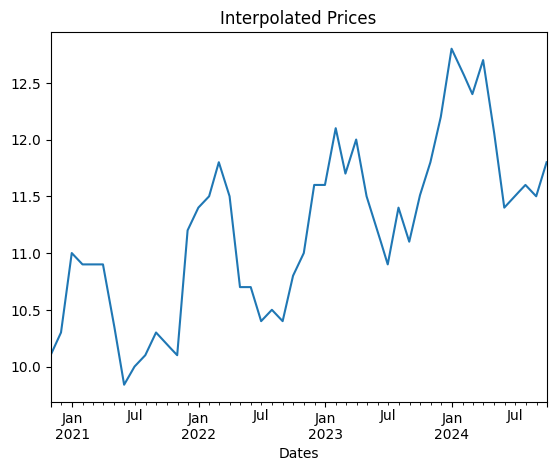

In [8]:
df_interpolated['Prices'].plot(title = 'Interpolated Prices')
plt.show()

## Moving Averages

**Plotting the Data**

**Moving Average**

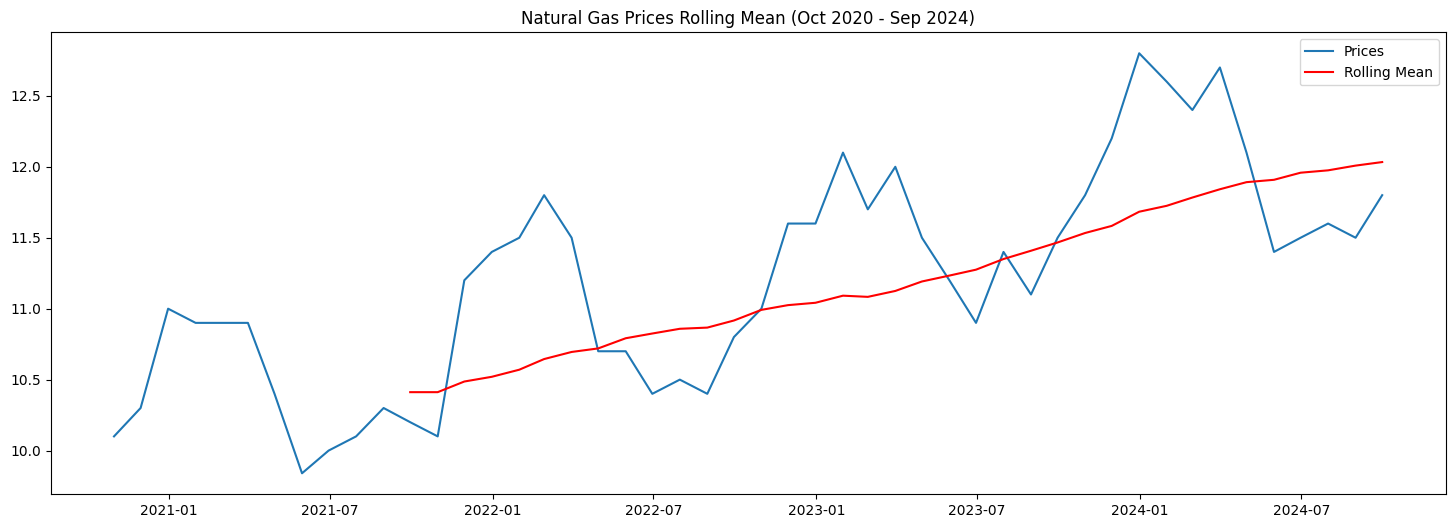

In [9]:
plt.figure(figsize = (18,6))
plt.plot(df, label = 'Prices')
plt.title("Natural Gas Prices Rolling Mean (Oct 2020 - Sep 2024)")
rolling_mean = df.rolling(window=12).mean().set_index(df.index)
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend()
plt.show()

**Moving Variance**

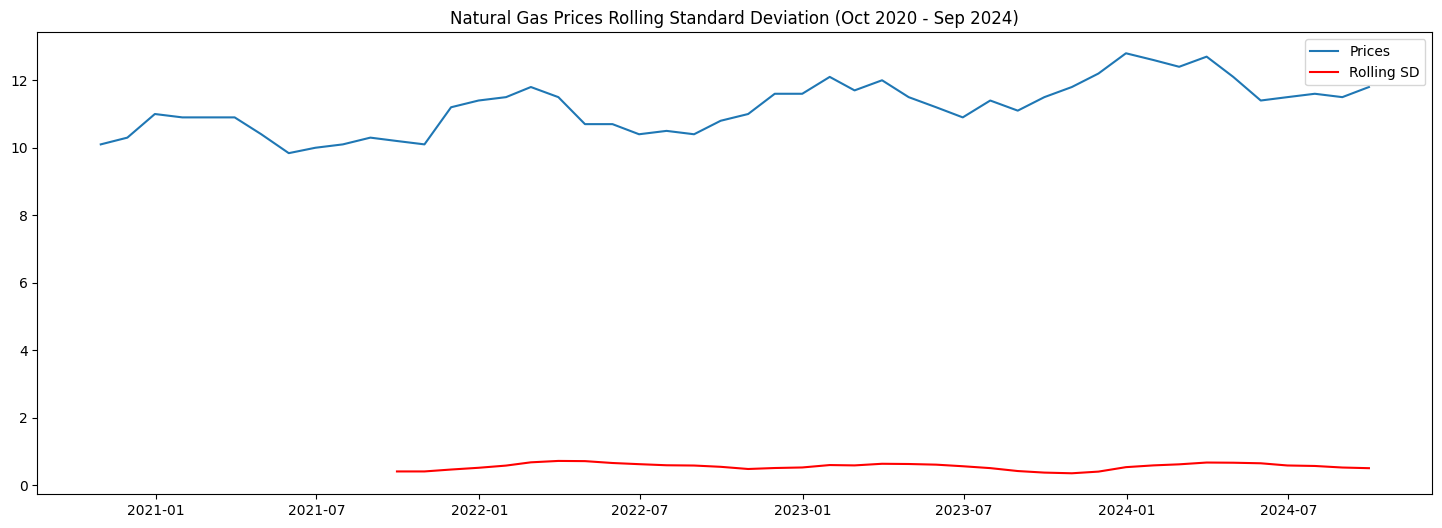

In [10]:
plt.figure(figsize = (18,6))
plt.plot(df, label = 'Prices')
plt.title("Natural Gas Prices Rolling Standard Deviation (Oct 2020 - Sep 2024)")
rolling_std = df.rolling(window=12).std().set_index(df.index)
plt.plot(rolling_std, color='red', label='Rolling SD')
plt.legend()
plt.show()

___Inferences:___
 - The data is **not stationary** as the moving average is not constant.
 - The data shows clear **seasonality** as the prices can be seen going down between April and September/October of every year, and then back up again. <br>
To confirm the non-stationarity of the data, we will also administer the **Augmented Dickey-Fuller Test.**

#### Augmented Dickey-Fuller Test
 - **H0**: The time series is not stationary.
 - **H1**: The time series is stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
result = adfuller(df['Prices'])
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: 0.22
5% Critical Value: -2.94
p-value: 0.97


___Inferences:___
 - In the above test, the p-value is much higher than 0.05.
 - Therefore, our null hypothesis stands corrected.
 - The given time series is **not stationary**.

#### Seasonality Analysis

Prior to transforming the data, we will also conduct a seasonlity analysis on the data to check for trends, seasonality and revenues.

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

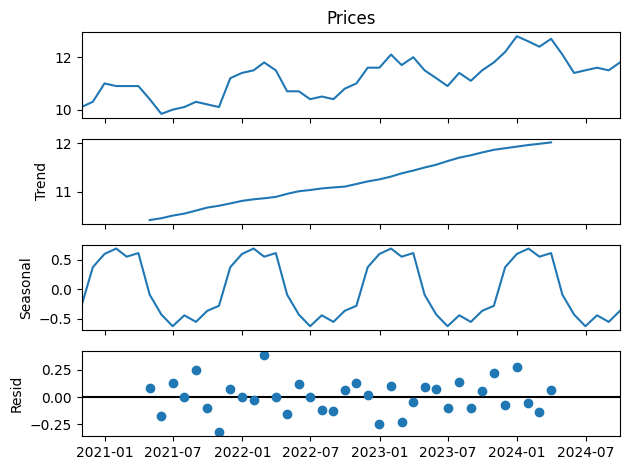

In [14]:
seasonal_analysis = seasonal_decompose(df['Prices'], model = 'additive', period = 12)
seasonal_analysis.plot()
plt.show()

___Inferences:___
 - A clear trend and seasonality can be seen from the above graphs.

### Transforming into Stationary Series

Since the moving average is not constant but the moving variance is somehwat constant, we will start with **differencing transformation**.

We see no much significant difference in the stationarity yet. Hence, we will use **Differencing** method next.

In [15]:
df_diff = (df - df.shift()).dropna()

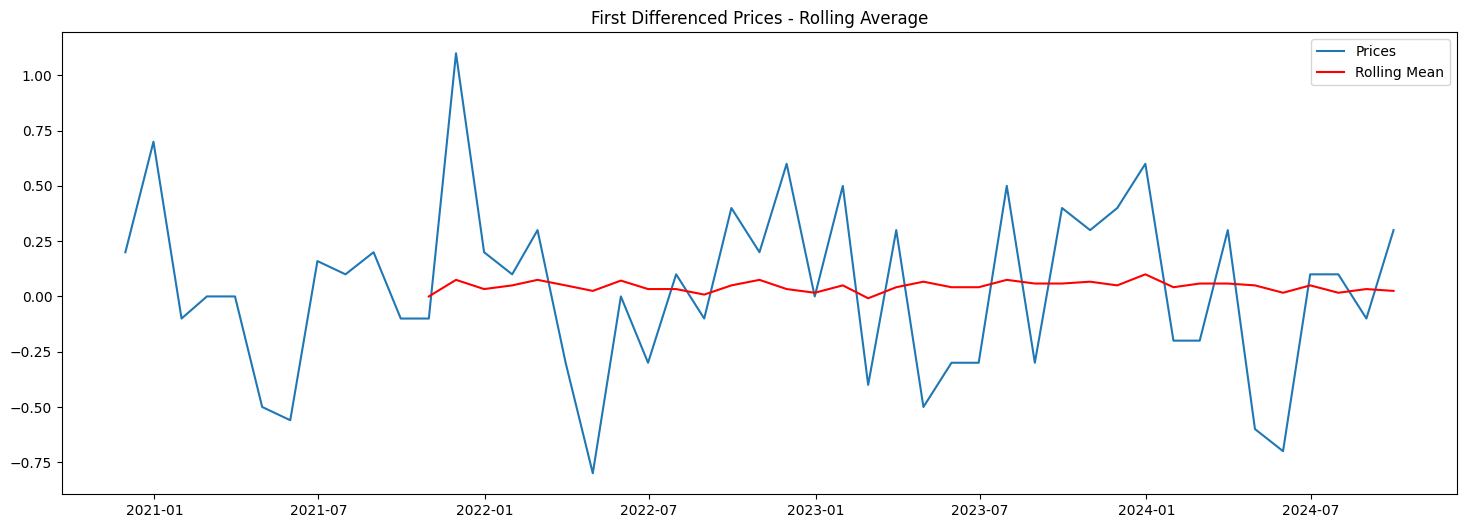

In [16]:
plt.figure(figsize = (18,6))
plt.plot(df_diff, label = 'Prices')
rolling_mean_2 = df_diff.rolling(window=12).mean().set_index(df_diff.index)
plt.plot(rolling_mean_2, color='red', label='Rolling Mean')
plt.title("First Differenced Prices - Rolling Average")
plt.legend()
plt.show()

Now, we can see that the moving average has become somewhat constant, and thus, the data has also become stationary. <br>
To confirm this stationarity, we will again use the **Augmented Dickey-Fuller Test**.

In [17]:
result = adfuller(df_diff['Prices'])
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -6.84
5% Critical Value: -2.94
p-value: 0.00


As the p-value is 0 (i.e., less than 0.05), thus the null hypothesis can be rejected. <br>
Therefore, data is now **stationary**.

### Splitting data into training and testing sets

In [18]:
test_months = 12
train = df_diff[:-test_months].dropna()
train.tail()

,Prices
Dates,
2023-05-31,-0.3
2023-06-30,-0.3
2023-07-31,0.5
2023-08-31,-0.3
2023-09-30,0.4


In [19]:
test = df_diff[-test_months:]
test

,Prices
Dates,
2023-10-31,0.3
2023-11-30,0.4
2023-12-31,0.6
2024-01-31,-0.2
2024-02-29,-0.2
2024-03-31,0.3
2024-04-30,-0.6
2024-05-31,-0.7
2024-06-30,0.1


### Model Development for Testing

In [20]:
from pmdarima import auto_arima

**Fitting the model**

In [21]:
sarima_model = auto_arima(train['Prices'], seasonal = True, m = 6, D = 1)
print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   35
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 6)   Log Likelihood                  -9.256
Date:                             Wed, 17 Jul 2024   AIC                             34.512
Time:                                     12:20:11   BIC                             45.451
Sample:                                 11-30-2020   HQIC                            37.938
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0635      0.266      0.238      0.812      -0.458       0.585
ar.L1         -0.4631      

**Predictions**

In [22]:
raw_test_predictions = sarima_model.predict(n_periods = 12)
raw_test_predictions

2023-10-31    0.079906
2023-11-30    0.805449
2023-12-31    0.055920
2024-01-31    0.441642
2024-02-29   -0.263784
2024-03-31    0.310449
2024-04-30   -0.645455
2024-05-31   -0.243403
2024-06-30   -0.121968
2024-07-31    0.427242
2024-08-31   -0.373944
2024-09-30    0.567622
Freq: ME, dtype: float64

**Plotting test vs predicted prices**

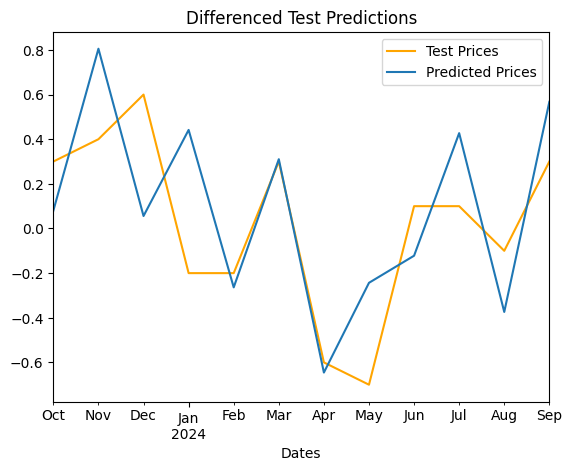

In [23]:
test['Prices'].plot(title = 'Differenced Test Predictions', color = 'orange', label = 'Test Prices')
raw_test_predictions.plot(label = 'Predicted Prices')
plt.legend()
plt.show()

**Model Evaluation**

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
print(f"Root Mean Squared Error (RMSE): {mean_squared_error(df_diff['Prices'][-12:], raw_test_predictions, squared = False)}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(df_diff['Prices'][-12:], raw_test_predictions)}")

Root Mean Squared Error (RMSE): 0.34620653671515184
Mean Absolute Error (MAE): 0.28986055539697636


After experimenting with various kinds of models and parameters, this model best fits the testing data with its predictions.

## Predicting 1 Year Price Values

**Fitting the forecast model**

In [23]:
sarima_future_model = auto_arima(df_diff['Prices'], seasonal = True, m = 6, D = 1)
print(sarima_future_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   47
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 6)   Log Likelihood                  -8.275
Date:                             Wed, 17 Jul 2024   AIC                             34.551
Time:                                     12:21:03   BIC                             49.973
Sample:                                 11-30-2020   HQIC                            40.167
                                      - 09-30-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.006      0.030      0.976      -0.012       0.012
ar.L1          1.5658      

#### Forecasting 1 Year Prices

In [24]:
forecast_diff = sarima_future_model.predict(n_periods = test_months)
forecast_diff

2024-10-31    0.385337
2024-11-30    0.274702
2024-12-31    0.602768
2025-01-31   -0.039007
2025-02-28   -0.138068
2025-03-31    0.134730
2025-04-30   -0.444861
2025-05-31   -0.671553
2025-06-30    0.123246
2025-07-31    0.111482
2025-08-31   -0.095491
2025-09-30    0.295288
Freq: ME, dtype: float64

**Inversing Differencing**

In [25]:
forecast_cumsum = forecast_diff.cumsum()
forecast_cumsum

2024-10-31    0.385337
2024-11-30    0.660039
2024-12-31    1.262807
2025-01-31    1.223801
2025-02-28    1.085732
2025-03-31    1.220463
2025-04-30    0.775602
2025-05-31    0.104048
2025-06-30    0.227294
2025-07-31    0.338777
2025-08-31    0.243285
2025-09-30    0.538574
Freq: ME, dtype: float64

In [26]:
forecast = pd.Series(df[-12:]['Prices'].iloc[0], index=forecast_cumsum.index)
forecast = forecast.add(forecast_cumsum, fill_value=0)
forecast = pd.DataFrame(forecast)
forecast.rename(columns = {0:'Prices'}, inplace = True)
forecast.head()

,Prices
2024-10-31,12.185337
2024-11-30,12.460039
2024-12-31,13.062807
2025-01-31,13.023801
2025-02-28,12.885732


#### Final Forecasted Prices

In [27]:
df_with_predictions = pd.concat([df, forecast])
df_with_predictions.tail()

,Prices
2025-05-31,11.904048
2025-06-30,12.027294
2025-07-31,12.138777
2025-08-31,12.043285
2025-09-30,12.338574


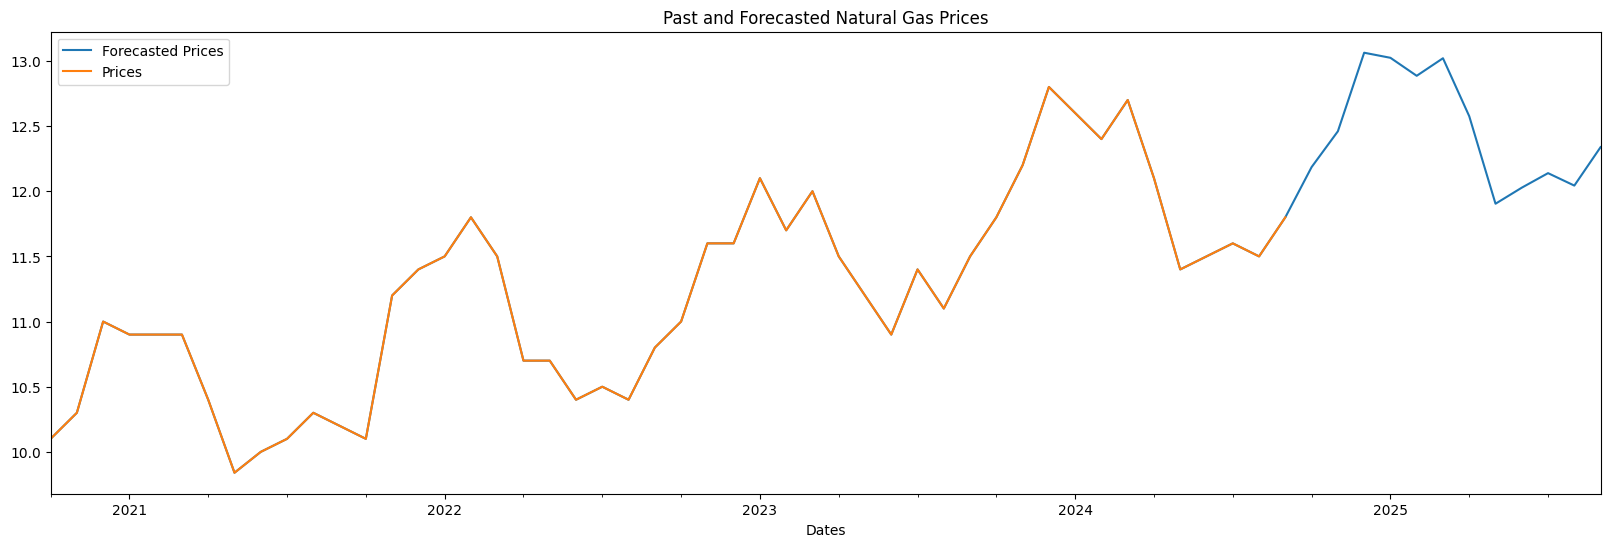

In [28]:
plt.figure(figsize = (20,6))
df_with_predictions['Prices'].plot(label = "Forecasted Prices")
df['Prices'].plot(title = 'Past and Forecasted Natural Gas Prices')
plt.legend()
plt.show()

#### Interpolating Values
Interpolating given dataset to estimate the purchase price of gas at any date in the past or 1 year into the future.

In [29]:
df_future_interpolated = df_with_predictions.resample('D').mean()
df_future_interpolated['Prices'] = df_future_interpolated['Prices'].interpolate()
df_future_interpolated.head()

,Prices
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667


In [30]:
df_future_interpolated.tail()

,Prices
2025-09-26,12.299202
2025-09-27,12.309045
2025-09-28,12.318888
2025-09-29,12.328731
2025-09-30,12.338574


In [31]:
df_future_interpolated.to_csv('Forecast.csv')